In [106]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import hashlib
import os
from datetime import datetime, timedelta

In [107]:
# ======================
# Data Preprocessing for Alert Dataset
# ======================

# Mapping of entity types to their relevant feature columns
entity_feature_map = {
    'User': ['Roles', 'AccountSid', 'LastVerdict', 'Usage', 'Category', 'AlertTitle'],
    'File': ['Sha256', 'FileName', 'FolderPath', 'Usage', 'Category', 'AlertTitle'],
    'RegistryValue': ['RegistryKey', 'RegistryValueName', 'RegistryValueData', 'Category', 'AlertTitle'],
    'RegistryKey': ['RegistryKey', 'RegistryValueName', 'RegistryValueData', 'Category', 'AlertTitle'],
    'AzureResource': ['ResourceIdName', 'DeviceId', 'Category', 'Usage', 'AlertTitle'],
    'Machine': ['DeviceId', 'OSFamily', 'OSVersion', 'Roles', 'Usage', 'Category', 'AlertTitle'],
    'Process': ['FileName', 'FolderPath', 'Sha256', 'ThreatFamily', 'Usage', 'Category', 'AlertTitle'],
    'Ip': ['IpAddress', 'CountryCode', 'Usage', 'Roles', 'Category', 'AlertTitle'],
    'Url': ['Url', 'LastVerdict', 'Usage', 'Category', 'AlertTitle'],
    'CloudApplication': ['ApplicationId', 'Usage', 'Category', 'AlertTitle'],
    'GenericEntity': ['Usage', 'Category', 'AlertTitle'],
    'Malware': ['Sha256', 'DeviceId', 'Usage', 'Category', 'AlertTitle'],
    'CloudLogonRequest': ['DeviceId', 'Usage', 'Category', 'AlertTitle'],
    'CloudLogonSession': ['DeviceId', 'Usage', 'Category', 'AlertTitle'],
    'Mailbox': ['AccountSid', 'Roles', 'Usage', 'LastVerdict', 'Category', 'AlertTitle'],
    'MailCluster': ['EmailClusterId', 'Usage', 'LastVerdict', 'Category', 'AlertTitle'],
    'MailMessage': ['AccountSid', 'NetworkMessageId', 'AntispamDirection', 'Roles', 'LastVerdict', 'Usage', 'Category', 'AlertTitle'],
    'MailboxConfiguration': ['AccountUpn', 'LastVerdict', 'Usage', 'Category', 'AlertTitle'],
    'OAuthApplication': ['ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'Roles', 'LastVerdict', 'Usage', 'Category', 'AlertTitle'],
    'Blob': ['Sha256', 'Url', 'Usage', 'Category', 'AlertTitle']
}

def preprocess_dataset(csv_path, sample_frac=0.3, chunksize=10000, num_buckets=500):
    """
    Reads, cleans, and transforms the raw alert CSV dataset for ML modeling.
    Performs sampling, label encoding, one-hot encoding, feature hashing, and normalization.
    Returns: Model input array, labels, processed DataFrame, feature-index map, non-feature info, original rows.
    """
    # -------- Helper: Hashing categorical features to numeric buckets --------
    def hash_feature(val, num_buckets=10000):
        if pd.isna(val):
            return 0
        return int(hashlib.md5(str(val).encode()).hexdigest(), 16) % num_buckets

    # --------- Step 1: Read and sample data ---------
    # Reads in CSV file in chunks and concatenates a fraction of each chunk (downsampling)
    df = pd.concat(
        [chunk.sample(frac=sample_frac) for chunk in pd.read_csv(csv_path, chunksize=chunksize)],
        ignore_index=True
    )

    # --------- Step 2: Label encoding and cleaning ---------
    # Map IncidentGrade to integer class (FalsePositive=0, BenignPositive=1, TruePositive=2)
    df['Label'] = df['IncidentGrade'].map({'FalsePositive': 0, 'BenignPositive': 1, 'TruePositive': 2})

    # Remove rows without a valid label
    df = df.dropna(subset=['Label'])

    # Add binary column: whether there was a response action taken (1 if ActionGranular exists, else 0)
    df['HasResponseAction'] = df['ActionGranular'].notna().astype(int)

    # Ensure all timestamps are parsed as datetimes for correct sorting
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # --------- Step 3: Prepare feature and non-feature lists ---------
    exclude_cols = {
        'IncidentGrade', 'Label', 'ActionGranular', 'ActionGrouped', 'Timestamp',
        'Id', 'OrgId', 'IncidentId', 'DetectorId', 'EvidenceRole', 'MitreTechniques'
    }
    allCols = []             # Full row dicts (for reference or downstream use)
    feature_rows = []        # Only features for ML model
    non_feature_rows = []    # Only non-feature columns (e.g., AlertId, EntityType, Timestamp)
    labels = []              # Encoded label for each row

    # Iterate over each row, select features based on entity type
    for _, row in df.iterrows():
        entity_type = row.get('EntityType', '')
        selected_features = entity_feature_map.get(entity_type, [])
        if not selected_features:
            continue  # Skip rows without feature mapping

        # ---- Features for ML model ----
        feature_row = {f: row.get(f, "0") for f in selected_features}
        feature_row['EntityType'] = entity_type
        feature_row['HasResponseAction'] = row['HasResponseAction']
        feature_rows.append(feature_row)

        # ---- Non-feature columns (metadata/reference) ----
        non_feature_rows.append({
            "AlertId": row.get("AlertId"),
            "EntityType": entity_type,
            "Timestamp": row.get("Timestamp")
        })

        # Label for supervised learning
        labels.append(int(row['Label']))
        allCols.append(dict(row))

    # Create DataFrame for ML features
    df_model = pd.DataFrame(feature_rows).fillna("0")

    # --------- Step 4: One-hot encoding ---------
    # Columns to be one-hot encoded (if they exist in the DataFrame)
    categorical_cols = [
        col for col in [
            'EntityType', 'Category', 'Usage', 'Roles', 'ThreatFamily', 
            'AntispamDirection', 'ResourceType', 'LastVerdict', 'SuspicionLevel'
        ] if col in df_model.columns
    ]
    df_model = pd.get_dummies(df_model, columns=categorical_cols, dummy_na=True)

    # --------- Step 5: Hash selected categorical features ---------
    # These columns are converted to numeric by hashing (fixed bucket size)
    hash_cols = [
        col for col in [
            'AlertTitle', 'DeviceId', 'IpAddress', 'AccountSid', 'AccountUpn', 'Sha256', 'Url',
            'FileName', 'FolderPath', 'RegistryKey', 'RegistryValueName', 'RegistryValueData',
            'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'ResourceIdName',
            'CountryCode', 'OSFamily', 'OSVersion', 'EmailClusterId', 'NetworkMessageId'
        ] if col in df_model.columns
    ]

    # Hash all relevant columns (including any remaining object columns)
    for col in hash_cols + list(df_model.select_dtypes(include='object').columns):
        df_model[col] = df_model[col].apply(lambda x: hash_feature(x, num_buckets))

    # --------- Step 6: Normalize all numeric columns ---------
    # Scales all numeric features to [0, 1] range for model input
    for col in df_model.select_dtypes(include=[np.number]).columns:
        min_val, max_val = df_model[col].min(), df_model[col].max()
        if max_val != min_val:
            df_model[col] = (df_model[col] - min_val) / (max_val - min_val)

    # --------- Step 7: Final assembly ---------
    # Features (X), labels (y), column index map, non-feature info, full raw row dicts
    X = df_model.values.astype(np.float32)
    y = np.array(labels).astype(int)
    feature_index = {col: idx for idx, col in enumerate(df_model.columns)}
    non_feature_df = pd.DataFrame(non_feature_rows)

    return X, y, df_model, feature_index, non_feature_df, allCols

In [115]:
# ======================
# DQN Model for SOC Alert Triage
# ======================

# ---------------------------------------
# Deep Q-Network (DQN) architecture
# ---------------------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Simple feedforward network: input -> 2x ReLU layers -> output
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

# ---------------------------------------
# RL Agent for SOC Alert Triage with DQN
# ---------------------------------------
class AlertTriageRL:
    def __init__(self, input_dim, output_dim=3, epsilon=1.0, epsilon_min=0.3, epsilon_decay=0.99995, device=None, lr=0.00025):
        # Device setup
        self.device = device or torch.device("cpu")
        # DQN policy and target networks
        self.policy_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net = DQN(input_dim, output_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        # Training
        self.lr = lr
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=10000)
        self.output_dim = output_dim
        # Epsilon-greedy exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.train_step_counter = 0
        self.target_update_frequency = 100
        self.action_counter = Counter()
        self.input_dim = input_dim
        self.prev_actions = {}
        # History for burst/visibility/adaptive reward calculations
        self.alert_history_log = []  # Stores dicts of past alerts
        self.non_feature = None

    # ---------------------------
    # Action selection (Epsilon-greedy)
    # ---------------------------
    def select_action(self, state, exploit_only=False):
        if exploit_only or random.random() >= self.epsilon:
            # Exploit: pick best action from policy net
            with torch.no_grad():
                action = self.policy_net(torch.FloatTensor(state)).argmax().item()
        else:
            # Explore: random action
            action = random.randint(0, self.output_dim - 1)
        self.action_counter[action] += 1
        return action

    # ---------------------------
    # Base reward calculation (ground truth, analyst match, response taken)
    # ---------------------------
    def reward_base(self, truth_label, match=False, redundant=False, has_responded=False):
        reward_truth = 0.0
        if truth_label == 2:  # True Positive
            reward_truth = 1.0
        elif truth_label == 1:  # Benign
            reward_truth = 0.5
        elif truth_label == 0:  # False Positive
            reward_truth = -1.0

        reward_analyst = 0.0
        if match and not redundant:
            reward_analyst = 1.0
        elif not match and redundant:
            reward_analyst = -1.0

        reward_soar = 0.0
        if has_responded:
            if truth_label == 2:
                reward_soar = 1.0
            elif truth_label == 1:
                reward_soar = 0.5
            elif truth_label == 0:
                reward_soar = -1.0

        return [reward_truth, reward_analyst, reward_soar]

    # ---------------------------
    # Reward for attack category/criticality
    # ---------------------------
    def reward_category(self, category):
        category_criticality = {
            'Impact': 1.0, 'Exfiltration': 1.0,
            'CommandAndControl': 0.8, 
            'PrivilegeEscalation': 0.7, 
            'LateralMovement': 0.8,
            'CredentialAccess': 0.8, 
            'Ransomware': 0.8, 
            'Execution': 0.7,
            'Persistence': 0.7, 
            'DefenseEvasion': 0.7, 
            'Malware': 0.6,
            'CredentialStealing': 0.6, 
            'InitialAccess': 0.6, 
            'Discovery': 0.5,
            'Collection': 0.5, 
            'Exploit': 0.4, 
            'SuspiciousActivity': 0.3, 
            'UnwantedSoftware': 0.2
        }
        return category_criticality.get(category, 0.2)

    # ---------------------------
    # Reward for "burst" detection (frequency of similar alerts in time window)
    # ---------------------------
    def reward_burst(self, alert_features, feature_index, allCols_row, current_time, alert_history, time_window_minutes=30):
        entity_value_feature_map = {
            'User': 'AccountSid', 
            'File': 'FileName', 
            'RegistryValue': 
            'RegistryValueName',
            'RegistryKey': 'RegistryKey', 
            'AzureResource': 'ResourceIdName', 
            'Machine': 'DeviceId',
            'Process': 'FileName', 
            'Ip': 'IpAddress', 
            'Url': 'Url'
        }
        # 1. Find entity type from one-hot encoding
        entity_type = None
        for etype in entity_value_feature_map.keys():
            col = f'EntityType_{etype}'
            if col in feature_index and alert_features[feature_index[col]] == 1:
                entity_type = etype
                break
        # 2. Get the entity value from raw row
        if entity_type in entity_value_feature_map:
            entity_value = allCols_row.get(entity_value_feature_map[entity_type], None)
        else:
            entity_value = allCols_row.get('AlertTitle', None)
        alert_title = allCols_row.get('AlertTitle', None)

        if entity_value is None:
            return False, None, 0, entity_type, entity_value

        burst_count = 0
        most_recent_diff = None
        from datetime import timedelta, datetime
        time_window = timedelta(minutes=time_window_minutes)

        if isinstance(current_time, str):
            try:
                current_time = datetime.fromisoformat(current_time.replace('Z', '+00:00'))
            except Exception:
                pass

        burst_matches = []
        for hist in alert_history:
            if hist['EntityType'] == entity_type and hist['EntityValue'] == entity_value:
                hist_time = hist['Timestamp']
                if isinstance(hist_time, str):
                    try:
                        hist_time = datetime.fromisoformat(hist_time.replace('Z', '+00:00'))
                    except Exception:
                        continue
                time_diff = current_time - hist_time
                if timedelta(0) <= time_diff <= time_window:
                    burst_count += 1
                    if most_recent_diff is None or time_diff < most_recent_diff:
                        most_recent_diff = time_diff
                    burst_matches.append({
                        "AlertTitle": hist.get("AlertTitle", ""),  
                        "EntityType": hist.get("EntityType", ""),
                        "EntityValue": hist.get("EntityValue", ""),
                        "Timestamp": hist_time.strftime("%Y-%m-%d %H:%M:%S") if hasattr(hist_time, 'strftime') else str(hist_time)
                    })
        # Debug output
        if burst_count > 0:
            print("\n[BURST DEBUG] Burst matches found:")
            print(f"{'AlertTitle':<30} | {'EntityType':<15} | {'EntityValue':<20} | {'Timestamp'}")
            print("-" * 85)
            for match in burst_matches:
                print(f"{str(match['AlertTitle']):<30} | {str(match['EntityType']):<15} | {str(match['EntityValue']):<20} | {str(match['Timestamp'])}")
            print("-" * 85 + "\n")
        is_burst = burst_count > 0
        time_diff_seconds = most_recent_diff.total_seconds() if most_recent_diff else None
        return is_burst, time_diff_seconds, burst_count, entity_type, entity_value

    # ---------------------------
    # Reward based on entity visibility (public/private, criticality)
    # ---------------------------
    def reward_visibility(self, entity_type, usage):
        visibility_reward_table = {
            'Ip': {'Public': 1.0, 'Private': 0.6},
            'Url': {'Public': 1.0, 'Private': 0.6},
            'User': {'Public': 0.7, 'Private': 1.0},
            'Machine': {'Public': 0.7, 'Private': 1.0},
            'File': {'Public': 0.5, 'Private': 0.9},
            'Process': {'Public': 0.6, 'Private': 0.9},
            'AzureResource': {'Public': 1.0, 'Private': 0.7},
            'RegistryKey': {'Public': 0.3, 'Private': 0.8},
            'RegistryValue': {'Public': 0.3, 'Private': 0.8},
            'CloudApplication': {'Public': 1.0, 'Private': 0.7},
            'GenericEntity': {'Public': 0.5, 'Private': 0.7},
            'Malware': {'Public': 0.9, 'Private': 0.9},
            'CloudLogonRequest': {'Public': 1.0, 'Private': 0.7},
            'CloudLogonSession': {'Public': 1.0, 'Private': 0.7},
            'Mailbox': {'Public': 0.7, 'Private': 1.0},
            'MailCluster': {'Public': 0.8, 'Private': 0.8},
            'MailMessage': {'Public': 0.8, 'Private': 0.8},
            'MailboxConfiguration': {'Public': 0.7, 'Private': 1.0},
            'OAuthApplication': {'Public': 0.8, 'Private': 0.8},
            'Blob': {'Public': 0.8, 'Private': 0.7},
        }
        usage_key = usage.capitalize()
        return visibility_reward_table.get(entity_type, {}).get(usage_key, 0.5)

    # ---------------------------
    # Reward adjustment based on previous actions
    # ---------------------------
    def reward_prev(self, prev_action, pred_action, true_label, match, redundant, has_response):
        # No previous action = neutral
        if prev_action is None:
            return 0.0

        reward = 0.0
        # (Shortened logic, see original for full variant)
        if prev_action == 2 and pred_action == 2:
            if true_label == 2:
                reward = 1.0
            elif true_label == 1:
                reward = -1.0
            else:
                reward = -1.0
        elif prev_action == 2 and pred_action == 1:
            if true_label == 2:
                reward = -0.5
            elif true_label == 1:
                reward = 1.0
            else:
                reward = -0.5
        elif prev_action == 2 and pred_action == 0:
            if true_label == 2:
                reward = -1.0
            elif true_label == 1:
                reward = 0.5
            else:
                reward = 1.0
        elif prev_action == 1 and pred_action == 2:
            if true_label == 2:
                reward = 1.0
            elif true_label == 1:
                reward = -1.0
            else:
                reward = -1.0
        elif prev_action == 1 and pred_action == 1:
            if true_label == 2:
                 reward = 0.5
            elif true_label == 1:
                 reward = 1.0
            else:
                reward = -0.5
        elif prev_action == 1 and pred_action == 0:
            if true_label == 2:
                reward = -1.0
            elif true_label == 1:
                reward = -0.5
            else:
                reward = 1.0
        elif prev_action == 0 and pred_action == 0:
            if true_label == 2:
                reward = -1.0
            elif true_label == 1:
                reward = -0.5
            else:
                reward = 1.0
        elif prev_action == 0 and pred_action == 1:
            if true_label == 2:
                reward = 1.0
            elif true_label == 1:
                reward = 1.0
            else:
                true_label = -0.5
        elif prev_action == 0 and pred_action == 2:
            if true_label == 2:
                reward = 1.0
            elif true_label == 1:
                reward = -0.5
            else:
                reward = -1.0
        return reward

    # ---------------------------
    # Compose adaptive reward from all factors
    # ---------------------------
    def compute_adaptive_reward(self, pred_action, true_label, base_score, cat_score, burst_score, v_score, prev_score, prev_action=None, match=False, redundant=False, has_response=False):  
        # Weight each reward component, and scale by action modifiers
        action_modifiers_base = {0: -1.0, 1: 1.0, 2: 1.0}
        base_score = [x * action_modifiers_base.get(pred_action, 0.0) for x in base_score]
        base_score = sum(base_score)

        w1 = 0.25
        cat_score = w1 * cat_score
        cat_score = cat_score * action_modifiers_base.get(pred_action, 0.0)

        w2 = 0.30
        burst_score = w2 * burst_score
        burst_score = burst_score * {0: 1.0, 1: -1.0, 2: -1.0}.get(pred_action, 0.0)

        w3 = 0.20
        v_score = w3 * v_score

        w4 = 0.25
        prev_score = w4 * prev_score
        prev_score = prev_score * action_modifiers_base.get(pred_action, 0.0)

        reward = base_score + cat_score + burst_score + v_score + prev_score

        if pred_action == 2 and true_label == 0:
            print(f"DEBUG: Auto-Respond chosen for False Positive!")
            print(f"    base_score={base_score}, cat_score={cat_score}, burst_score={burst_score}, v_score={v_score}, prev_score={prev_score}, total_reward={reward}")
        return reward

    # ---------------------------
    # Main agent update: get action, calculate rewards, log and train
    # ---------------------------
    def update_from_analyst(self, alert_features, alert_nonfeatures, feature_index, allCols_row, true_label, match=False, redundant=False):
        has_response = bool(alert_features[feature_index['HasResponseAction']])
        state = np.array(alert_features).astype(np.float32)
        action = self.select_action(state)
        key = alert_features[feature_index['AlertTitle']]
        prev_action = self.prev_actions.get(key)
        self.non_feature = alert_nonfeatures

        # Calculate each reward component

        # Base Reward
        base_score = self.reward_base(true_label, match, redundant, has_response)

        # Category
        category_columns = [k for k in feature_index.keys() if k.startswith('Category_')]
        for col in category_columns:
            if alert_features[feature_index[col]] == 1:
                category_stage = col.replace('Category_', '')
                break
        else:
            category_stage = None
        cat_score = self.reward_category(category_stage)

        # Burst logic (log count within recent window)
        is_burst, time_diff_seconds, burst_count, entity_type, entity_value = self.reward_burst(
            alert_features=alert_features,
            feature_index=feature_index,
            allCols_row=allCols_row,
            current_time=alert_nonfeatures['Timestamp'],
            alert_history=self.alert_history_log,
            time_window_minutes=30
        )
        if burst_count > 0:
            import math
            burst_score = math.log10(burst_count + 1)
            #print(f'Burst Count for action {action} is: {burst_count}')
        else:
            burst_score = 0.0

        # Visibility
        v_score = self.reward_visibility(allCols_row.get('EntityType', ''), allCols_row.get('Usage', ''))

        # Reward for following history
        prev_score = self.reward_prev(prev_action, action, true_label, match, redundant, has_response)

        # Log alert into burst/visibility history (sliding window of 1000)
        if len(self.alert_history_log) > 1000:
            self.alert_history_log.pop(0)
        self.alert_history_log.append({
            "EntityType": entity_type,
            "EntityValue": entity_value,
            "Timestamp": alert_nonfeatures['Timestamp'],
            "AlertTitle": allCols_row.get("AlertTitle", ""),
        })

        # Total adaptive reward
        reward = self.compute_adaptive_reward(
            pred_action=action,
            true_label=true_label,
            base_score=base_score,
            cat_score=cat_score,
            burst_score=burst_score,
            v_score=v_score,
            prev_score=prev_score,
            prev_action=prev_action,
            match=match,
            redundant=redundant,
            has_response=has_response
        )
        if key is not None:
            self.prev_actions[key] = action
        self.memory.append((state, action, reward, state, True))
        self.train_dqn()

        # Also log again for history (possible redundancy, consider removing)
        if len(self.alert_history_log) > 1000:
            self.alert_history_log.pop(0)
        self.alert_history_log.append({
            "EntityType": entity_type,
            "EntityValue": entity_value,
            "Timestamp": alert_nonfeatures['Timestamp'],
            "AlertTitle": allCols_row.get('AlertTitle', 'None')
        })    


    # ---------------------------
    # DQN training step (sample minibatch from memory)
    # ---------------------------
    def train_dqn(self, batch_size=32, gamma=0.9):
        """
        Performs a single DQN training step using a random minibatch from memory.
        Updates the policy network weights and periodically syncs the target network.
        """
        if len(self.memory) < batch_size:
            return  # Not enough samples to train yet
    
        # Sample random transitions (state, action, reward, next_state, done)
        batch = random.sample(self.memory, batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
    
        # Convert all to PyTorch tensors and send to correct device
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.LongTensor(action_batch).to(self.device).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        done_batch = torch.BoolTensor(done_batch).to(self.device).unsqueeze(1)
    
        # Current Q-values for taken actions
        q_values = self.policy_net(state_batch).gather(1, action_batch)
    
        # Next Q-values for next state (max over all actions)
        next_q_values = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)
    
        # Compute target Q-values using Bellman equation
        expected_q = reward_batch + gamma * next_q_values * (~done_batch)
    
        # Compute loss (e.g., MSE between current and expected Q-values)
        loss = self.criterion(q_values, expected_q)
    
        # Standard backward pass
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
    
        # Step counter and occasional target net update
        self.train_step_counter += 1
        if self.train_step_counter % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


    # ======================
    # Model Save and Load Utilities
    # ======================
    
    def save_model(self, path="alert_triage_model.pth"):
        """
        Saves the DQN agent's state to disk for future resume or inference.
        Stores network weights, optimizer, epsilon, input dimension, and feature columns.
        """
        # Note: df_model.columns must exist in the outer scope or be tracked inside the class.
        torch.save({
            'input_dim': self.input_dim,                             # Number of model input features
            'policy_net': self.policy_net.state_dict(),              # Policy network weights
            'target_net': self.target_net.state_dict(),              # Target network weights
            'optimizer': self.optimizer.state_dict(),                # Optimizer state
            'epsilon': self.epsilon,                                 # Current epsilon (exploration rate)
            'feature_columns': list(df_model.columns)                # List of feature columns (for preprocessing alignment)
        }, path)
        print(f"💾 Model saved to {path}")
    
    def load_model(self, path="alert_triage_model.pth"):
        """
        Loads the DQN agent's state from a checkpoint file.
        Restores network weights, optimizer state, epsilon, and feature columns.
        """
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)
    
        # ---- Step 1: Restore model architecture ----
        self.input_dim = checkpoint['input_dim']
        self.policy_net = DQN(self.input_dim, self.output_dim).to(self.device)
        self.target_net = DQN(self.input_dim, self.output_dim).to(self.device)
    
        # ---- Step 2: Load saved weights and optimizer state ----
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.optimizer.load_state_dict(checkpoint['optimizer'])
    
        # ---- Step 3: Restore exploration epsilon and feature columns ----
        self.epsilon = checkpoint.get('epsilon', self.epsilon)
        self.feature_columns = checkpoint.get('feature_columns', [])
    
        print(f"✅ Model loaded from {path} with input_dim={self.input_dim}")

In [116]:
# ======================
# Training SOC Alert Triage RL Model (DQN)
# ======================

# ---- Configurations ----
csv_path = "Dataset/GUIDE_20K.csv"
sample_frac = 0.999                # Use almost the entire dataset
model_path = "trained_alert_triage.pth"
train_on_old_data = False           # Set True to resume training from previous model
num_epochs = 1                      # 🔁 Increase for more training cycles

# ---- Device Selection ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# ========================================
# Step 1: Preprocess Data
# ========================================
X_temp, y, df_model, feature_index, non_feature_df, allCols = preprocess_dataset(csv_path, sample_frac)

# ========================================
# Step 2: Initialize DQN Model
# ========================================
rl_model = AlertTriageRL(input_dim=X_temp.shape[1], device=device)

# ========================================
# Step 3: Optionally Load Model for Resume Training
# ========================================
if os.path.exists(model_path) and train_on_old_data:
    rl_model.load_model(model_path)
    # Ensure DataFrame columns match model's expected feature order
    df_model = df_model.reindex(columns=rl_model.feature_columns, fill_value=0)
    X = df_model.values.astype(np.float32)
else:
    X = X_temp  # Use freshly preprocessed features

sample_size = int(len(X) * sample_frac)  # Determine number of training samples

# ========================================
# Step 4: Setup Epsilon (Exploration Rate) Decay
# ========================================
epsilon_values = []
step_counter = 0
epsilon_start = 1.0
epsilon_end = 0.01
total_steps = sample_size * num_epochs
decay_rate = -np.log(epsilon_end / epsilon_start) / total_steps

print("📊 Feature Index:", feature_index)

# ========================================
# Step 5: Main Training Loop
# ========================================
for epoch in range(num_epochs):
    print(f"\n🌀 Epoch {epoch + 1}/{num_epochs}")
    indices = np.random.choice(len(X), sample_size, replace=False)  # Shuffle sample indices

    for i in indices:
        alert_features = X[i]
        true_label = y[i]
        # Update epsilon using exponential decay schedule
        rl_model.epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-decay_rate * step_counter)
        epsilon_values.append(rl_model.epsilon)
        
        # Retrieve metadata/non-feature fields for the current alert
        alert_nonfeatures = non_feature_df.iloc[i]
        alert_id = alert_nonfeatures['AlertId']
        alertTitle = alert_features[feature_index['AlertTitle']]  # Still hashed

        # Train on this single sample (simulate RL step)
        rl_model.update_from_analyst(
            alert_features,
            alert_nonfeatures,
            feature_index,
            allCols[i],
            true_label,
            match=False,
            redundant=False
        )
        step_counter += 1

        # Log progress occasionally
        if i % 1000 == 0:
            print(f"Training step {i}, Epsilon: {rl_model.epsilon:.4f}")
    print(f"🔁 End of epoch {epoch + 1} | Epsilon: {rl_model.epsilon:.4f}")

print("✅ Training Complete")

# ========================================
# Step 6: Save Trained Model
# ========================================
rl_model.save_model(model_path)

🚀 Using device: cpu
📊 Feature Index: {'DeviceId': 0, 'OSFamily': 1, 'OSVersion': 2, 'AlertTitle': 3, 'HasResponseAction': 4, 'IpAddress': 5, 'CountryCode': 6, 'AccountSid': 7, 'Url': 8, 'NetworkMessageId': 9, 'Sha256': 10, 'FileName': 11, 'FolderPath': 12, 'ApplicationId': 13, 'EmailClusterId': 14, 'RegistryKey': 15, 'RegistryValueName': 16, 'RegistryValueData': 17, 'ResourceIdName': 18, 'ApplicationName': 19, 'OAuthApplicationId': 20, 'AccountUpn': 21, 'EntityType_AzureResource': 22, 'EntityType_Blob': 23, 'EntityType_CloudApplication': 24, 'EntityType_CloudLogonRequest': 25, 'EntityType_CloudLogonSession': 26, 'EntityType_File': 27, 'EntityType_GenericEntity': 28, 'EntityType_Ip': 29, 'EntityType_Machine': 30, 'EntityType_MailCluster': 31, 'EntityType_MailMessage': 32, 'EntityType_Mailbox': 33, 'EntityType_MailboxConfiguration': 34, 'EntityType_Malware': 35, 'EntityType_OAuthApplication': 36, 'EntityType_Process': 37, 'EntityType_RegistryKey': 38, 'EntityType_RegistryValue': 39, 'Ent

In [117]:
# ======================
# Evaluation of Trained Alert Triage RL Model
# ======================

# ---- Step 1: Load Evaluation Data ----
csv_path = "Dataset/GUIDE_20K.csv"
sample_frac = 0.99  # Use most/all of dataset for robust evaluation

# Select computation device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Preprocess the evaluation data
X_test, y_test, df_model, feature_index, non_feature_df, allCols = preprocess_dataset(csv_path, sample_frac)

# ---- Step 2: Load Trained RL Model ----
rl_model = AlertTriageRL(input_dim=X_test.shape[1], device=device)
rl_model.load_model("trained_alert_triage.pth")

# Make sure the test DataFrame columns match the trained model's feature order
df_model = df_model.reindex(columns=rl_model.feature_columns, fill_value=0)
X_test = df_model.values.astype(np.float32)

# ---- Step 3: Inference/Evaluation ----
# For each test sample, select action (exploit_only=True means use policy only, no randomness)
predicted_labels = [
    rl_model.select_action(x, exploit_only=True) for x in X_test
]

# Calculate accuracy
correct = sum(int(pred == actual) for pred, actual in zip(predicted_labels, y_test))
accuracy = correct / len(y_test)

#print(f"\n📊 Test Accuracy: {accuracy * 100:.2f}%")
print("📊 Prediction Distribution:", Counter(predicted_labels))
print("📊 Actual Distribution:", Counter(y_test))

# ---- Step 4: Misclassification/Results Table ----
# Build a DataFrame to analyze predictions, misclassifications, and action types
results = pd.DataFrame({
    "Actual Label": y_test,
    "Predicted Label": predicted_labels,
    "Classification": [ ["Filter", "Prioritize", "Auto-Respond"][p] for p in predicted_labels ], 
    "HasResponseAction": X_test[:, feature_index['HasResponseAction']].astype(int)
})

# Show top 30 predictions for review
results.head(30)

🚀 Using device: cpu
✅ Model loaded from trained_alert_triage.pth with input_dim=89
📊 Prediction Distribution: Counter({1: 13329, 2: 5639, 0: 828})
📊 Actual Distribution: Counter({np.int64(1): 8380, np.int64(2): 7108, np.int64(0): 4308})


,Actual Label,Predicted Label,Classification,HasResponseAction
0,1,1,Prioritize,0
1,2,2,Auto-Respond,0
2,2,2,Auto-Respond,0
3,2,1,Prioritize,0
4,2,2,Auto-Respond,0
5,2,1,Prioritize,0
6,0,2,Auto-Respond,0
7,1,1,Prioritize,0
8,1,2,Auto-Respond,0
9,1,1,Prioritize,0


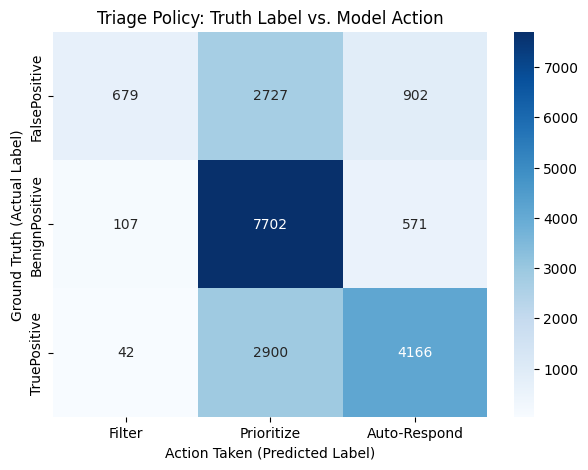

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Names for axes: True label (vertical), Action taken (horizontal)
actual_names = ["FalsePositive", "BenignPositive", "TruePositive"]
action_names = ["Filter", "Prioritize", "Auto-Respond"]

cm = confusion_matrix(results['Actual Label'], results['Predicted Label'], labels=[0,1,2])

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=action_names, yticklabels=actual_names
)
plt.xlabel("Action Taken (Predicted Label)")
plt.ylabel("Ground Truth (Actual Label)")
plt.title("Triage Policy: Truth Label vs. Model Action")
plt.show()
